# Bear Spring EPM (Equivalent Porous Media) Model

Model started 10/14/24 by Charles Soucey. Modeled after Langevin, C. 2024, UMN Hydrocamp  
[Link to Reference Code](https://github.com/langevin-usgs/umn2024/tree/main)

Iterated and updated by Jenny Huang.

In [7]:
# import python packages
import pathlib as pl #Pathlib used for switching between directories, accessing files
import numpy as np #for numerical operations
import matplotlib.pyplot as plt #for creating plots
from matplotlib.ticker import FormatStrFormatter
 
import pandas as pd #for handling dataframes
import flopy #Used for interacting with MODFLOW, developing MODFLOW inputs and reading outputs
import rasterio #For working with raster data and shapefiles
from rasterio import features
import geopandas as gpd #For importing shapefiles
import shapely as shp
import networkx as nx
import geojson
import os
import sys
import importlib
import yaml
import seaborn as sns
import pykasso as pk


In [8]:
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../../src"))) #use this to be able to import local packages

In [61]:
import utils.utils
import utils.config
import utils.creeks
import utils.calibration
importlib.reload(utils.utils)
importlib.reload(utils.config)
importlib.reload(utils.creeks)
importlib.reload(utils.calibration)
from utils.config import *
from utils.utils import *
from utils.creeks import *
from utils.calibration import * 

In [62]:
test = Config('EPM_2layer.yaml')
test.load_polygon('watershed', 'springshed', 'subdomain')
test.merge_polygons('merged', 'watershed_polygon', 'springshed_polygon')
test.load_creeks()
test.set_domain('subdomain_polygon')
test.apply_DEM_to_domain()
start = test.creeks.return_coordinates(186)[-1]
nearest = get_nearest_point(start, test.merged_polygon)
test.creeks.extend_creek(start, nearest)
start = test.creeks.return_coordinates(154)[-1]
nearest = get_nearest_point(start, test.merged_polygon)
test.creeks.extend_creek(start, nearest)
test.creeks.clip_creek(test.domain, 10)
test.load_karst_features()
test.extract_grid_params_from_domain()
test.extract_top_config()
test.extract_bottom_config()
test.create_grid()
test.extract_idomain()
test.extract_K_values()
test.extract_creek_cells()
springshed_cells = test.extract_polygon_cells(test.springshed_polygon)
springshed_top = np.hstack([np.zeros((springshed_cells.shape[0], 1)), springshed_cells])
springshed_botm = np.hstack([np.ones((springshed_cells.shape[0], 1)), springshed_cells])
test.set_K_values(springshed_top, Kh = test.Kh_ss[0], Kv = test.Kv_ss[0])
test.set_K_values(springshed_botm, Kh = test.Kh_ss[1], Kv = test.Kv_ss[1])

new config loaded from EPM_2layer.yaml


In [64]:
test.import_conduit_network(verbose = True)
test.set_conduit_K_vals(verbose = True)

loaded network from conduit_network/bs_10.npy
updated 4157 cells with Kh = 1000Kv = 500


c:\Users\huan1428\Documents\karst\UMNBearSpring\src\utils\config.py:199: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_func = plt.cm.get_cmap(cmap)


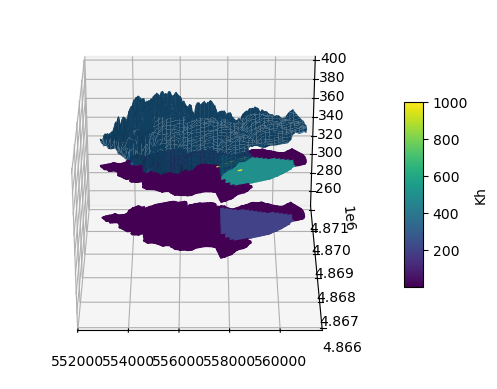

In [68]:
test.plot_model_grid_layers(test.Kh_vals,azim = 270, elev = 30, cmap = 'viridis', var_name = 'Kh')

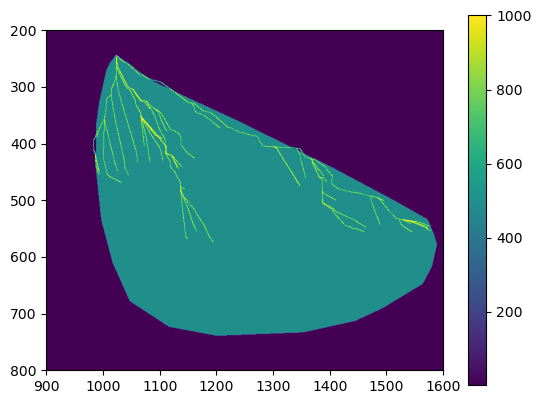

In [75]:
plt.imshow(test.Kh_vals[0])
plt.xlim(900, 1600)
plt.ylim(800, 200)
plt.colorbar()

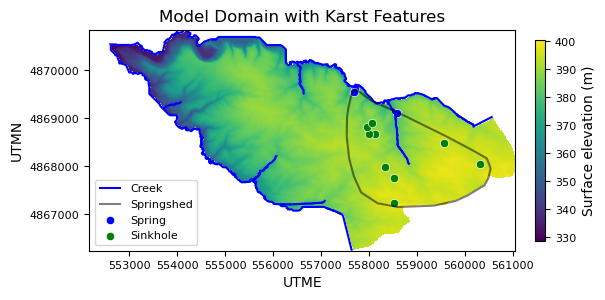

In [22]:
fig, ax = plt.subplots()
plt.imshow(np.ma.masked_where(test.idomain[0] == 0, test.dem_grid), extent = [test.total_bounds[0], test.total_bounds[2], test.total_bounds[1], test.total_bounds[3]])
colorbar = plt.colorbar(label = 'Surface elevation (m)', shrink = 0.5, fraction=0.1, pad=0.04)
colorbar.ax.set_position([0.85, 0.01, 0.05, 0.7])  # [left, bottom, width, height]

colorbar.ax.tick_params(labelsize = 8)
test.creeks.plot(ax = ax, label = 'Creek', color = 'blue')
test.plot_polygons('springshed_polygon', boundary = True, color = 'black', ax= ax, alpha= 0.5, label = 'Springshed')
test.domain.boundary.plot(ax = ax, alpha = 1, color = 'black')

sns.scatterplot(test.spring,x = 'UTME', y = 'UTMN', color = 'blue', label = 'Spring')
sns.scatterplot(test.sink,x = 'UTME', y = 'UTMN', color = 'green', label = 'Sinkhole' )
plt.title('Model Domain with Karst Features')
plt.xticks(fontsize = 8)
plt.yticks(fontsize = 8)

ax.xaxis.set_major_formatter(FormatStrFormatter('%1.6s'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%1.7s'))
plt.legend(loc='lower left', bbox_to_anchor=(0,0), fontsize = 8)
plt.tight_layout()

plt.savefig('../../../figs/dem_model_domain.png', bbox_inches = 'tight', transparent = True)


In [73]:
# row = test.creek_cells[:,0]
# col = test.creek_cells[:,1]
# lay = 0
# elev = test.get_cell_elev(row, col)
# C = 400 #m/d
drn_spd = test.extract_drain_spd()
test.make_sim(lenuni = "METER", ws = 'model_runs/EPM_springshed_test')
test.add_npf_module()
test.add_recharge_module()
test.add_drains_module()

package_name = drn_0
filename = EPM_steady_state.drn
package_type = drn
model_or_simulation_package = model
model_name = EPM_steady_state

Block options
--------------------
print_flows
{internal}
(True)

save_flows
{internal}
(True)


Block period
--------------------
stress_period_data
{internal}
(      cellid_layer  cellid_row  cellid_column        elev  cond
0                0           0            309  334.819733    10
1                0           0            310  334.908783    10
2                0           0            311  335.247498    10
3                0           0            312  335.595551    10
4                0           0            313  335.667847    10
...            ...         ...            ...         ...   ...
6447             0         919           1009  389.455933    10
6448             0         920           1009  389.506226    10
6449             0         247           1024  373.009979    50
6450             0         258           1019  376.582642  

In [74]:
test.run_sim()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims...
  writing model EPM_steady_state...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package oc...
    writing package npf...
    writing package rcha_0...
    writing package drn_0...
INFORMATION: maxbound in ('gwf6', 'drn', 'dimensions') changed to 6452 based on size of stress_period_data
FloPy is using the following executable to run the model: ..\..\..\..\..\..\modflow\mf6.5.0_win64par\bin\mf6.exe
                               MODFLOW 6 EXTENDED
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.5.0 05/23/2024

   MODFLOW 6 compiled May 23 2024 18:08:14 with Intel(R) Fortran Intel(R) 64
  Compiler Classic for applications running on Intel(R) 64, Version 2021.11.1
                             Build 20231117_000000

This software has been approved for release by

(True, [])

In [76]:
test.load_sim(ws = 'model_runs/EPM_springshed_test')
test.load_model()
test.read_head_output()
test.read_drain_discharge_output()

loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package dis...
    loading package ic...
    loading package oc...
    loading package npf...
    loading package rch...
    loading package drn...
  loading solution package epm_steady_state...


(              cellid        elev  cond         dis
 0        (0, 0, 309)  334.819733    10   -7.904041
 1        (0, 0, 310)  334.908783    10   -7.369602
 2        (0, 0, 311)  335.247498    10   -4.518620
 3        (0, 0, 312)  335.595551    10   -1.502471
 4        (0, 0, 313)  335.667847    10   -0.939873
 ...              ...         ...   ...         ...
 6447  (0, 919, 1009)  389.455933    10   -5.333215
 6448  (0, 920, 1009)  389.506226    10   -4.837765
 6449  (0, 247, 1024)  373.009979    50 -507.886003
 6450  (0, 258, 1019)  376.582642    50 -332.865910
 6451  (0, 348, 1197)  378.804810    50 -241.879077
 
 [6452 rows x 4 columns],
 array([[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],
 
        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0

In [78]:
test.drain_spd

,cellid,elev,cond,dis
0,"(0, 0, 309)",334.819733,10,-7.904041
1,"(0, 0, 310)",334.908783,10,-7.369602
2,"(0, 0, 311)",335.247498,10,-4.518620
3,"(0, 0, 312)",335.595551,10,-1.502471
4,"(0, 0, 313)",335.667847,10,-0.939873
...,...,...,...,...
6447,"(0, 919, 1009)",389.455933,10,-5.333215
6448,"(0, 920, 1009)",389.506226,10,-4.837765
6449,"(0, 247, 1024)",373.009979,50,-507.886003
6450,"(0, 258, 1019)",376.582642,50,-332.865910


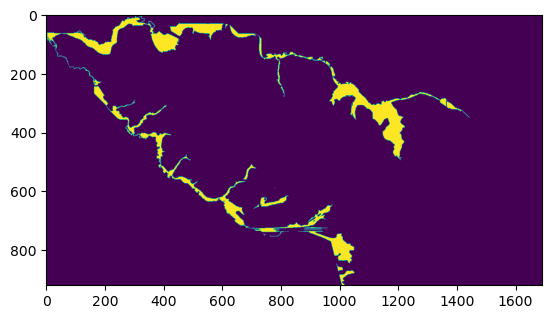

In [77]:
plt.imshow(test.check_head_above_land_surface('bool'))

c:\Users\huan1428\Documents\karst\UMNBearSpring\src\utils\config.py:188: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_func = plt.cm.get_cmap(cmap)


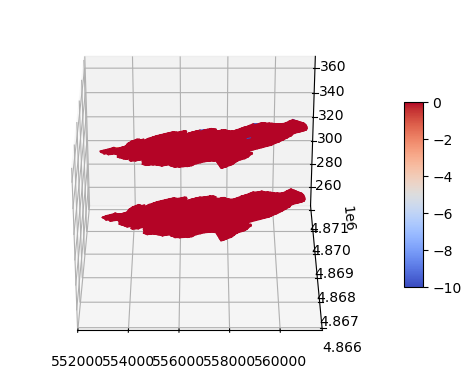

In [38]:
test.plot_model_grid_layers(test.drain_array, azim = 270, show_surface = False, cmap = 'coolwarm', vmin = -10)

<Axes: xlabel='UTME', ylabel='UTMN'>

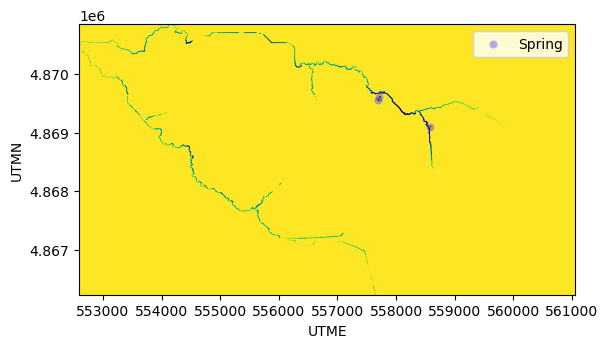

In [13]:
plt.imshow(test.drain_array[0], vmin = -10, vmax = 0, cmap = 'viridis', extent = [test.total_bounds[0], test.total_bounds[2], test.total_bounds[1], test.total_bounds[3]])
sns.scatterplot(test.spring,x = 'UTME', y = 'UTMN', color = 'blue', label = 'Spring', alpha = 0.3)



In [79]:
model = test.sim.get_model('EPM_steady_state')
heads = model.output.head().get_data(idx = 0)
heads[heads > 1e10] = np.nan

c:\Users\huan1428\Documents\karst\UMNBearSpring\src\utils\config.py:199: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_func = plt.cm.get_cmap(cmap)


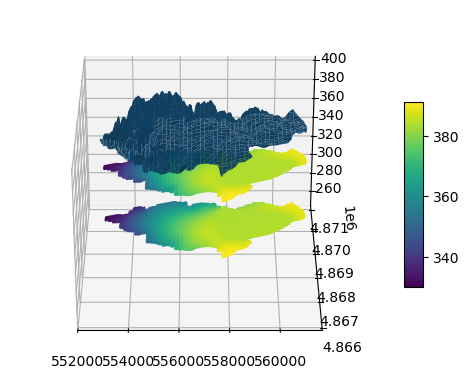

In [80]:
test.plot_model_grid_layers(test.heads, azim = 270)

c:\Users\huan1428\Documents\karst\UMNBearSpring\src\utils\config.py:199: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_func = plt.cm.get_cmap(cmap)


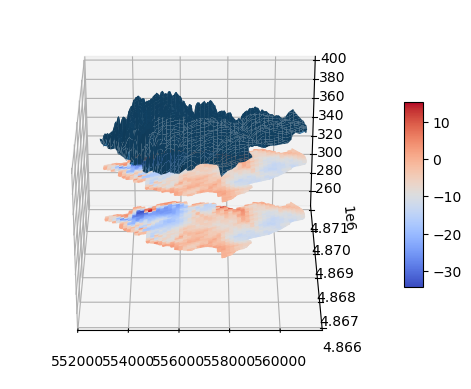

In [81]:
test.plot_model_grid_layers(heads - test.dem_grid, azim = 270, cmap = 'coolwarm')

## Calibration
- objective function:
    - compare MRSW head value
    - check for head above land surface
        - need to aggregate 
    - check head below bottom cell
        - also need to aggregate
    - check BS discharge (avg baseflow)
- methods needed
    - check_head(cell, true_val)
    - check_head_above_surface(heads, surface_elev):
    - check_discharge(cellid, true_val)
- variables to adjust:
    - C_creek
    - C_spring
    - Kh_1
    - Kh_2
    - Kv_1
    - Kv_2
- inverse modeling thing where I run a bunch of simulations with different permutations of the parameters 
- then I evaluate based on the objective function




In [28]:
mrsw = CalibrationData(name = 'mrsw', filename = '../../data/MRSW/MRSW_head_CSV.csv', UTME = 557091, UTMN = 4867265)
mrsw.convert_data_to_timeseries()

read ../../data/MRSW/MRSW_head_CSV.csv and set data
calibration obj mrsw created
updated data to time series


In [ ]:
bs_q = CalibrationData(name = 'bs_q', filename = '../../data/discharge/discharge_2017_2020.csv')
bs_q.convert_data_to_timeseries(datetime_col='date')
bs_q.set_cal_value(bs_q.data.rolling(window = '7D').mean().mean()['m3/d'])

read ../../data/discharge/discharge_2017_2020.csv and set data
calibration obj bs_q created
updated data to time series


calibration value set to 5731.253503013694


In [ ]:
bs_UTME, bs_UTMN = run.spring[run.spring.ID == '55A00572'].UTME.iloc[0], run.spring[run.spring.ID == '55A00572'].UTMN.iloc[0]
bs_cell_idx = run.get_cell_id_from_coords(bs_UTME, bs_UTMN)

In [74]:
bud = test.model.output.budget() #read budget
drain_dis = bud.get_data(text='DRN')[0]
drain_id = [id - 1 for (row, id, dis) in drain_dis] #get cell ids, subtract one to convert to 0-based indexing
dis = [dis for (row, id, dis) in drain_dis] #get discharge values
test.drain_spd.loc[drain_id,'dis'] = dis #append discharge to corresponding drains by ID 


In [ ]:
mrsw = CalibrationData(name = 'mrsw', filename = '../../data/MRSW/MRSW_head_CSV.csv', UTME = 557091, UTMN = 4867265)
mrsw.convert_data_to_timeseries()
mrsw.set_cal_value(mrsw.data['gw_elev[m]'][mrsw.data['gw_elev[m]'] > 0].mean())

calibration value set to 380.51831036348267


In [ ]:
mrsw_cell_idx = run.get_cell_id_from_coords(mrsw.UTME, mrsw.UTMN)
mrsw.get_residual(test.heads[0][mrsw_cell_idx])

38.68113527265996

<Axes: >

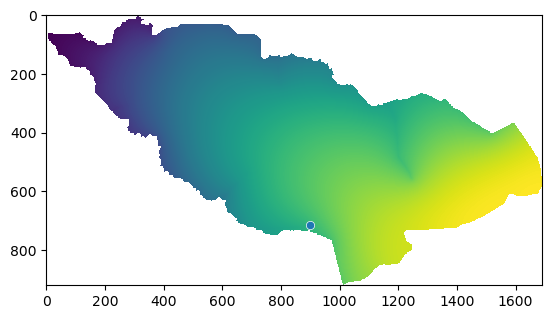

In [55]:
plt.imshow(test.heads[0], cmap = 'viridis') #, extent = [test.total_bounds[0], test.total_bounds[2], test.total_bounds[1], test.total_bounds[3]])
sns.scatterplot(x = [mrsw_cell_idx[1]], y = [mrsw_cell_idx[0]])
# sns.scatterplot(x = [mrsw.UTME], y = [mrsw.UTMN])


# Grid Search Results

In [53]:
results = pd.DataFrame()
data_dir = 'EPM_2layer'
for f in os.listdir(data_dir):
    try: 
        df = pd.read_csv(f'{data_dir}/{f}')
        results = pd.concat([results, df], axis = 0)
    except:
        print(f'skipping {f}')
results = results.drop_duplicates()
results = results.reset_index(drop = True)

skipping creeks_0.2_springs_10_Kh_10_1.0_Kv_0.1_0.1
skipping creeks_0.2_springs_10_Kh_10_1.0_Kv_0.2_0.1
skipping creeks_0.2_springs_10_Kh_10_1.0_Kv_0.30000000000000004_0.1
skipping creeks_0.2_springs_10_Kh_10_1.0_Kv_0.4_0.1
skipping creeks_0.2_springs_10_Kh_10_1.0_Kv_0.5_0.1
skipping creeks_0.2_springs_10_Kh_10_1.0_Kv_0.6_0.1
skipping creeks_0.2_springs_10_Kh_10_1.0_Kv_0.7000000000000001_0.1
skipping creeks_0.2_springs_10_Kh_10_1.0_Kv_0.8_0.1
skipping creeks_0.2_springs_10_Kh_10_1.0_Kv_0.9_0.1
skipping creeks_0.2_springs_10_Kh_10_1.0_Kv_1.0_0.1
skipping creeks_0.2_springs_10_Kh_10_1.0_Kv_1.1_0.1
skipping creeks_0.2_springs_10_Kh_10_1.0_Kv_1.1_1.1
skipping creeks_0.2_springs_10_Kh_10_1.0_Kv_1.2000000000000002_0.1
skipping creeks_0.2_springs_10_Kh_10_1.0_Kv_1.2000000000000002_1.1
skipping creeks_20_springs_100_Kh_0.1_0.1_Kv_0.2_0.1
skipping creeks_20_springs_10_Kh_0.1_0.1_Kv_0.2_0.2
skipping creeks_20_springs_20_Kh_0.1_0.1_Kv_0.2_0.2
skipping creeks_20_springs_30_Kh_0.1_0.1_Kv_0.2_0.2
sk

In [5]:
results = pd.read_csv('EPM_2layer/all_results.csv')

In [6]:
results

,Kh_0,Kh_1,Kv_0,Kv_1,C_spring,C_creek,success,mrsw_head,mrsw_error,bs_q,bs_error,head_above_surface_error,Kv_1_ss,Kv_0_ss,Kh_1_ss,Kh_0_ss,results_weighted_RMSE
0,7.1,1.1,0.1,0.1,250.0,2.0,True,384.399521,3.881210,-2307.430253,-8038.683756,116238.0,400.0,200.0,450.0,450.0,1.411132
1,7.1,1.1,0.1,0.1,250.0,2.0,False,NaN,NaN,NaN,NaN,NaN,400.0,200.0,450.0,450.0,NaN
2,7.1,1.1,0.1,0.1,250.0,2.0,True,384.404902,3.886592,2311.774663,-3419.478840,116585.0,400.0,200.0,450.0,450.0,0.616533
3,3.1,0.1,3.1,1.1,400.0,3.0,True,385.149905,4.631595,3220.417615,-2510.835888,205844.0,450.0,500.0,100.0,150.0,0.516717
4,3.1,1.1,2.1,0.1,200.0,7.0,True,383.170905,2.652595,1366.113572,-4365.139931,81749.0,100.0,350.0,150.0,300.0,0.769388
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9316,6.1,0.1,4.1,2.1,200.0,5.0,True,382.970828,2.452517,1346.714577,-4384.538926,69817.0,450.0,500.0,200.0,450.0,0.770662
9317,1.1,3.1,9.1,4.1,400.0,8.0,True,382.833903,2.315592,2209.561011,-3521.692492,62925.0,300.0,150.0,200.0,300.0,0.620172
9318,2.1,2.1,0.1,3.1,450.0,9.0,True,382.772507,2.254197,2594.850645,-3136.402858,68242.0,300.0,450.0,300.0,450.0,0.554750
9319,9.1,3.1,1.1,4.1,250.0,2.0,True,383.077272,2.558961,1740.753509,-3990.499994,91643.0,350.0,100.0,250.0,200.0,0.706886


In [30]:
results.mrsw_error = results.mrsw_head - mrsw.cal_value

In [101]:
results.to_csv('EPM_2layer/all_results.csv', index = False)

In [49]:
results_weighted_sum = np.sqrt((results.mrsw_error/mrsw.cal_value)**2 + (results.bs_error/bs_q.cal_value)**2 + (results.head_above_surface_error/results.head_above_surface_error.max())**2)

In [51]:
results['results_weighted_RMSE'] = results_weighted_sum

In [53]:
best_result = results[results.results_weighted_RMSE == results_weighted_sum.min()]

In [37]:
results[abs(results.mrsw_error) == abs(results.mrsw_error).min()]

,Kh_0,Kh_1,Kv_0,Kv_1,C_spring,C_creek,success,mrsw_head,mrsw_error,bs_q,bs_error,head_above_surface_error,Kv_1_ss,Kv_0_ss,Kh_1_ss,Kh_0_ss
2117,7.1,4.1,6.1,2.1,400.0,6.0,True,380.516851,-0.001459,1362.173964,-4369.079539,45005.0,100.0,300.0,300.0,450.0


In [ ]:
results[abs(results.bs_error) == abs(results.bs_error).min()]

,Kh_0,Kh_1,Kv_0,Kv_1,C_spring,C_creek,success,mrsw_head,mrsw_error,bs_q,bs_error,head_above_surface_error,Kv_1_ss,Kv_0_ss,Kh_1_ss,Kh_0_ss
3415,0.1,0.1,8.1,3.1,500.0,3.0,True,395.50537,14.987059,5735.538191,4.284688,616081.0,450.0,450.0,250.0,150.0


Text(0.5, 1.0, 'Error distribution in parameter space')

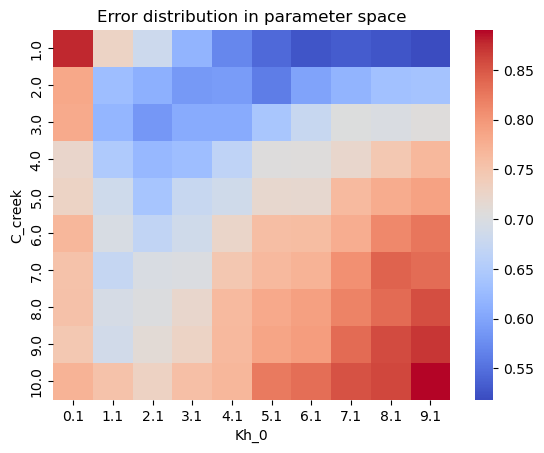

In [110]:
sns.heatmap(pd.pivot_table(data = results, values = 'results_weighted_RMSE', index = 'C_creek', columns = 'Kh_0'), cmap = 'coolwarm')
plt.title("Error distribution in parameter space")

In [56]:
def data_to_float(v):
    if isinstance(v, float):
        return v
    elif v.startswith('['):
        return eval(v)[0]
    else:
        return float(v)

In [59]:
results['bs_error'] = results['bs_error'].apply(
    data_to_float)

In [70]:
from sklearn.metrics import mutual_info_score

In [76]:
for col in results.columns: 
    if col == 'mrsw_head':
        continue
    temp = results[['mrsw_head', col]].dropna()
    mi = mutual_info_score(temp.mrsw_head, temp[col])
    print(f'{col}: {mi}')

Kh_0: 2.301144718732444
Kh_1: 1.6088301025049956
Kv_0: 2.3022672838295213
Kv_1: 1.6091612748597326
C_spring: 2.1968782043150332
C_creek: 2.302859850955547
success: 0.0
mrsw_error: 9.029417836095936
bs_q: 9.029417836095936
bs_error: 9.029417836095936
head_above_surface_error: 8.98830083125345
Kv_1_ss: 2.1968998840625797
Kv_0_ss: 2.196198024939274
Kh_1_ss: 2.196943777765247
Kh_0_ss: 2.1968384954908173


c:\Users\huan1428\.conda\envs\modflow\Lib\site-packages\sklearn\metrics\cluster\_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
c:\Users\huan1428\.conda\envs\modflow\Lib\site-packages\sklearn\metrics\cluster\_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
c:\Users\huan1428\.conda\envs\modflow\Lib\site-packages\sklearn\metrics\cluster\_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
c:\Users\huan1428\.conda\envs\modflow\Lib\site-packages\sklearn\metrics\cluster\_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continu

<Axes: xlabel='bs_error', ylabel='mrsw_error'>

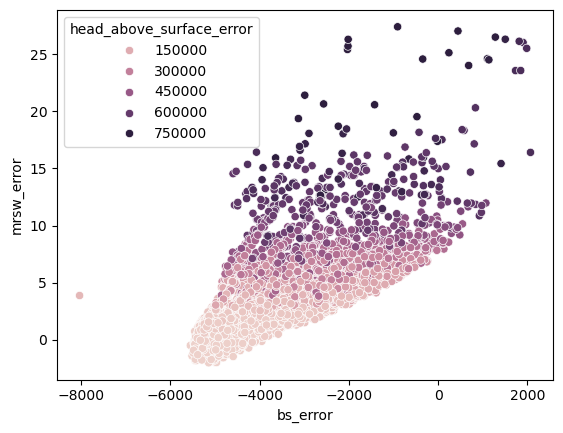

In [131]:
sns.scatterplot(results, x = 'bs_error', y = 'mrsw_error', hue = 'head_above_surface_error')

<Axes: xlabel='Kh_0_ss', ylabel='bs_error'>

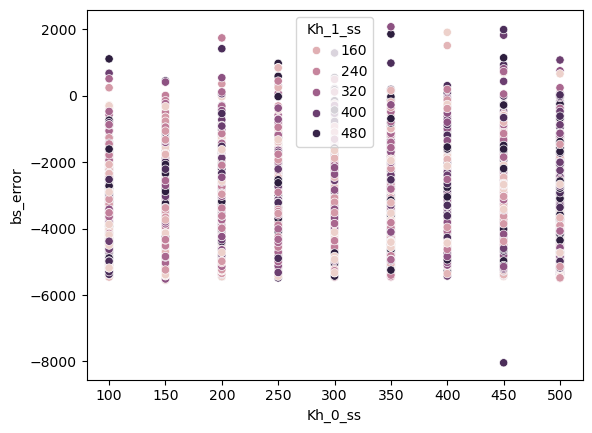

In [ ]:
sns.scatterplot(results, x = 'Kh_0_ss', y = 'bs_error', hue = 'Kh_1_ss')

# Running model for different years with best one

new config loaded from EPM_2layer_best.yaml
loaded watershed geojson
loaded springshed geojson
loaded creeks geojson
loaded subdomain geojson
loaded karst_features csv
loaded sinkholes csv
loaded precip csv
loaded recharge csv
extracted watershed polygon
extracted springshed polygon
extracted subdomain polygon
merged ('watershed_polygon', 'springshed_polygon')
loaded new Creek object from creeks data
set domain to subdomain_polygon
(552594.40655525, 4866235.880722723, 561054.4101949929, 4870845.335745172)
applied DEM ../../data/DEM/dem_1m_m.bil to domain
converted start tuple to Point
added segment from POINT (557455.9219013986 4866985.336331408) to POINT (557644.4070525824 4866235.880722723)

converted start tuple to Point
added segment from POINT (560184.9218932291 4868831.33646198) to POINT (560584.4090987638 4869035.8773543835)

clipped creeks
added sink
added spring
extracted grid params: 
Lx = 8460.003639742848
Ly = 4609.455022448674
nrow = 921
ncol = 1692
nlay = 2
set top to DEM

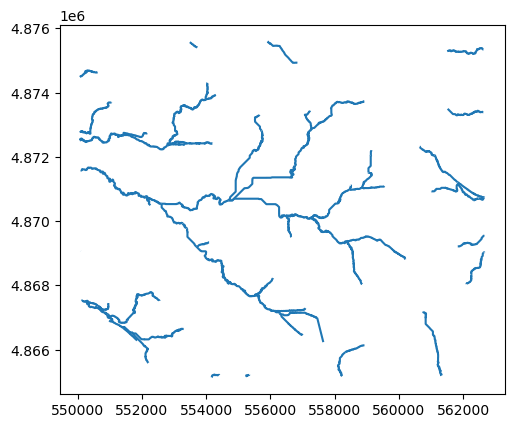

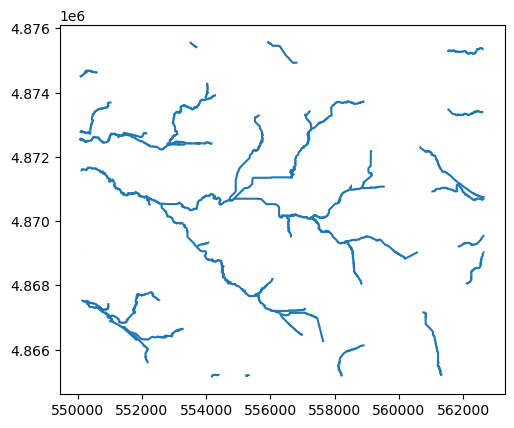

In [166]:
best_result = dict(best_result)
year = 2017

run = Config('EPM_2layer_best.yaml')
run.load_polygon('watershed', 'springshed', 'subdomain')
run.merge_polygons('merged', 'watershed_polygon', 'springshed_polygon')
run.load_creeks()
run.set_domain('subdomain_polygon')
run.apply_DEM_to_domain()
start = run.creeks.return_coordinates(186)[-1]
nearest = get_nearest_point(start, run.merged_polygon)
run.creeks.extend_creek(start, nearest)
start = run.creeks.return_coordinates(154)[-1]
nearest = get_nearest_point(start, run.merged_polygon)
run.creeks.extend_creek(start, nearest)
run.creeks.clip_creek(run.domain, 10)

run.load_karst_features()
run.extract_grid_params_from_domain()
run.extract_top_config()
run.extract_bottom_config()
run.create_grid()
run.import_idomain()
run.extract_creek_cells()
springshed_cells = run.extract_polygon_cells(run.springshed_polygon)
springshed_top = np.hstack([np.zeros((springshed_cells.shape[0], 1)), springshed_cells])
springshed_botm = np.hstack([np.ones((springshed_cells.shape[0], 1)), springshed_cells])


In [167]:
run.add_csv_data(recharge = f'../../data/recharge/{year}_recharge_zixuan.csv')
run.recharge = index_to_date(run.recharge, 'DATE')
run.recharge = run.recharge[run.recharge.index.year== year]['RCH[m/day]']

In [169]:
run.extract_K_values()
run.set_K_values(springshed_top, Kh = run.Kh_ss[0], Kv = run.Kv_ss[0])
run.set_K_values(springshed_botm, Kh = run.Kh_ss[1], Kv = run.Kv_ss[1])
drn_spd = run.extract_drain_spd()
run.make_sim(lenuni = "METER", ws = f'EPM_2layer_{year}')
run.add_npf_module(icelltype = 1)
run.add_recharge_module(rech = run.recharge.mean())
run.add_drains_module()
success, buff = run.run_sim()

extracted K values
updated 186270 cells with Kh = 500Kv = 250
updated 186270 cells with Kh = 400Kv = 400
added creeks to drain spd
added springs to drain spd
simulation created
time discretization added. 1 periods with 1 DAYS
iterative model solver added
gwf module added
discretization added
water table set with dtw = 1.58
set initial conditions
output control added
npf module created
recharge module created with r = 0.0010564303873626373
drains added
writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims...
  writing model EPM_steady_state...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package oc...
    writing package npf...
    writing package rcha_0...
    writing package drn_0...
INFORMATION: maxbound in ('gwf6', 'drn', 'dimensions') changed to 6452 based on size of stress_period_data
FloPy is using the following executable to run the model: ..\..\..\..\..\modfl

In [153]:
run.read_head_output()
run.read_drain_discharge_output()
mrsw_cell_idx = run.get_cell_id_from_coords(mrsw.UTME, mrsw.UTMN)
bs_q = CalibrationData(name = 'bs_q', filename = '../../data/discharge/discharge_2017_2020.csv')
bs_q.convert_data_to_timeseries(datetime_col='date')
bs_q.set_cal_value(bs_q.data[bs_q.data.index.year == year].rolling(window = '7D').mean().mean()['m3/d'])
bs_UTME, bs_UTMN = run.spring[run.spring.ID == '55A00572'].UTME.iloc[0], run.spring[run.spring.ID == '55A00572'].UTMN.iloc[0]
bs_of_UTME, bs_of_UTMN = run.spring[run.spring.ID == '55A00446'].UTME.iloc[0], run.spring[run.spring.ID == '55A00446'].UTMN.iloc[0]
bs_cell_idx = run.get_cell_id_from_coords(bs_UTME, bs_UTMN)
bs_of_idx = run.get_cell_id_from_coords(bs_of_UTME, bs_of_UTMN)
mrsw = CalibrationData(name = 'mrsw', filename = '../../data/MRSW/MRSW_head_CSV.csv', UTME = 557091, UTMN = 4867265)
mrsw.convert_data_to_timeseries()
mrsw.set_cal_value(mrsw.data[mrsw.data.index.year == year]['gw_elev[m]'][mrsw.data['gw_elev[m]'] > 0].mean())

results_yearly = {'year' : year}
results_yearly['mrsw_head'] = run.heads[0][mrsw_cell_idx]
results_yearly['mrsw_error'] = mrsw.get_residual(results_yearly['mrsw_head'])
results_yearly['bs_q'] = (run.drain_array[0][bs_cell_idx] + run.drain_array[0][bs_of_idx]) * -1
results_yearly['bs_error'] = bs_q.get_residual(results_yearly['bs_q'])
results_yearly['head_above_surface_error'] = run.check_head_above_land_surface(return_type = 'count')

heads data read to heads
read ../../data/discharge/discharge_2017_2020.csv and set data
calibration obj bs_q created
updated data to time series
calibration value set to 7166.6741261827565
read ../../data/MRSW/MRSW_head_CSV.csv and set data
calibration obj mrsw created
updated data to time series
calibration value set to 380.77904525966846


In [147]:
run.drain_spd[run.drain_spd.cellid == (0, 258, 1019)]

,cellid,elev,cond,dis
6450,"(0, 258, 1019)",376.582642,500,-3556.963096


Text(0.5, 1.0, 'Head above land surface')

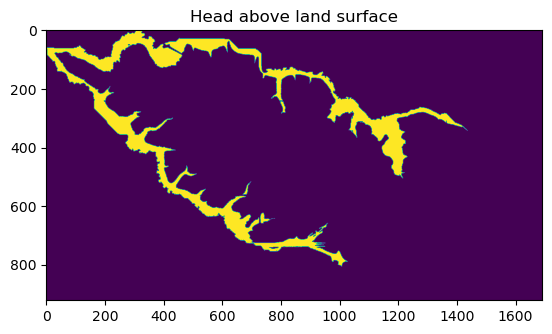

In [154]:
head_above_ls = run.check_head_above_land_surface(return_type= 'bool')
plt.imshow(head_above_ls)
plt.title("Head above land surface")

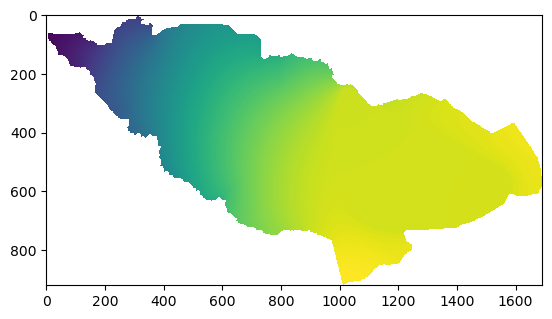

In [ ]:
plt.imshow(run.heads[0])

In [157]:
# all_yearly_results = pd.DataFrame(columns = results_yearly.keys())
all_yearly_results.loc[1] =results_yearly

In [158]:
all_yearly_results

,year,mrsw_head,mrsw_error,bs_q,bs_error,head_above_surface_error
1,2019,383.659146,2.8801,6269.400147,-897.273979,107945


# Conduits

In [13]:
network = np.load('conduit_network/bs_10.npy')

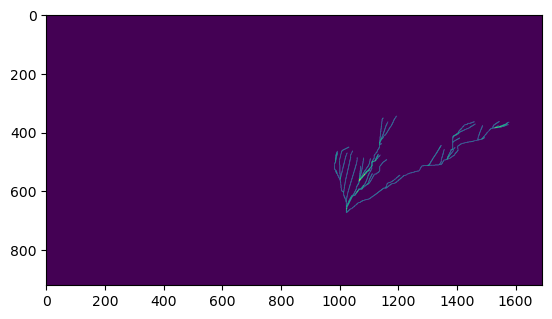

In [19]:
plt.imshow(network)

In [49]:
row, col = np.where(network == 1)
conduit_indices = [(0, network.shape[0] - 1 - r, c) for r, c in zip(row, col)]

In [50]:
test.set_K_values(conduit_indices, Kh = 1000, Kv = 1000)

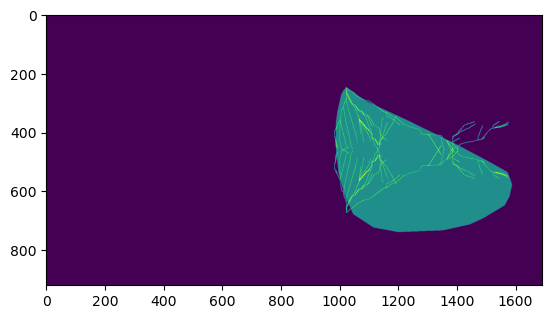

In [52]:
plt.imshow(test.Kh_vals[0])